In [1]:
import numpy as np
import pandas as pd
from scipy.special import erf
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import lognorm
import QuantLib as ql
import time as time
from pytictoc import TicToc
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from QuantLib import *
from datetime import datetime
from scipy.fft import fft, ifft, fftshift, ifftshift

In [2]:
#Compute Black-Scholes-Merton price of European options
#The model for the underlying is geometric Brownian motion

#Contract parameters
T=1 #maturity
K=1.1 #Strike

#Market parameters
S0=1 #spot price
r= 0.05 #risk-free interest rate
q= 0.02 #dividend rate

#model parameters
sigma=0.4 #volatility

#Monte Carlo parameters: npaths= nblocks*nsample
nblocks=2000 #number blocks
nsample=10000 #number of samples per block ie npaths per block

#Fourier parameters:
xwidth=6 #width of the support in real space
ngrid=2**8 #number of grid points
alpha=-10 #damping factor for a call

In [3]:
#Analytical solution:
muABM=r-q-0.5*sigma**2 #drift coefficient of the arithmetic Brownian motion
d2=(np.log(S0/K)+muABM*T)/(sigma*np.sqrt(T))
d1=d2+sigma*np.sqrt(T)
Vca=S0*np.exp(-q*T)*norm.cdf(d1,0,1)-K*np.exp(-r*T)*norm.cdf(d2,0,1)
Vpa=(K*np.exp(-r*T)*norm.cdf(-d2,0,1))-(S0*np.exp(-q*T)*norm.cdf(-d1,0,1))
put_call_parity=Vca+K*np.exp(-1*(r-q)*T)-S0
deviation=((put_call_parity/Vpa)-1)*100

In [4]:
#Analytical solution provided by Quantlib's package:
today=datetime.today()

maturity_date = ql.Date(int(today.strftime("%d")),int(today.strftime("%m")),int(today.strftime("%Y"))+1)
spot_price = S0
strike_price = K
volatility = sigma
dividend_rate =  q
call = ql.Option.Call
put = ql.Option.Put

risk_free_rate = r
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates()

calculation_date = ql.Date(int(today.strftime("%d")),int(today.strftime("%m")),int(today.strftime("%Y")))
ql.Settings.instance().evaluationDate = calculation_date

payoff_call = ql.PlainVanillaPayoff(call, strike_price)
payoff_put = ql.PlainVanillaPayoff(put, strike_price)
settlement = calculation_date
eu_exercise = ql.EuropeanExercise(maturity_date)
option_call = ql.VanillaOption(payoff_call, eu_exercise)
option_put = ql.VanillaOption(payoff_put, eu_exercise)

spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, risk_free_rate, day_count))
dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, dividend_rate, day_count))
flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, volatility, day_count))
bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)
engine=AnalyticEuropeanEngine(bsm_process)
option_call.setPricingEngine(engine)
option_put.setPricingEngine(engine)

In [5]:
from payoff import payoff #import payoff function from the payoff py file
#Fourier transform method

#Grids in real and Fourier space
N=ngrid/2
b=xwidth/2 #upper bound of the support in real space
dx=xwidth/ngrid #grid step in real space
x=dx*np.arange(-N,N,1) #grid in real space
dxi=np.pi/b #Nyquist relation: grid step in Fourier space
xi=dxi*np.arange(-N,N,1) #grid in Fourier space

#Characteristic function at time T
xia=xi+1j*alpha #for a call, in python you denote complex number as j
psi=1j*muABM*xia-0.5*(sigma*xia)**2 #characteristic exponent
Psic=np.exp(psi*T) #characteristic function
xia_p=xi-1j*alpha #for a put
psi_p=1j*muABM*xia_p-0.5*(sigma*xia_p)**2 #characteristic exponent
Psip=np.exp(psi_p*T) #characteristic function

#Fourier transform of the payoff
U=S0*np.exp(b)
L=S0*np.exp(-b)
S,gc,Gc=payoff(x,xi,alpha,K,L,U,S0,1)
S,gp,Gp=payoff(x,xi,-alpha,K,L,U,S0,-1)

#Discount expected payoff computed with the Plancherel theorem
c=(np.exp(-r*T)*np.real(fftshift(fft(ifftshift(Gc*np.conj(Psic))))))/xwidth
p=(np.exp(-r*T)*np.real(fftshift(fft(ifftshift(Gp*np.conj(Psip))))))/xwidth
VcF=np.interp(S0,S,c)
VcP=np.interp(S0,S,p)

In [6]:
#Monte Carlo:
VcMcb=np.zeros(nblocks)
VpMcb=np.zeros(nblocks)
testing=np.zeros(nblocks)

for k in range(nblocks):
    #Arithmetic Brownian motion X(T)=log(S(T)/S(0)) at time T
    X=muABM*T+sigma*np.random.randn(nsample)*np.sqrt(T)

    #Transform to geometric Brownian motion S(T) at time T
    S=S0*np.exp(X)

    #Discouned expected payoff
    VcMcb[k]=np.exp(-r*T)*np.mean(np.maximum(S-K,0))
    VpMcb[k]=np.exp(-r*T)*np.mean(np.maximum(K-S,0))

VcMC=np.mean(VcMcb)
VpMC=np.mean(VpMcb)
scMC=np.sqrt(np.var(VcMcb)/nblocks)
spMC=np.sqrt(np.var(VpMcb)/nblocks)

pricing_table=pd.DataFrame([Vpa,option_put.NPV(),VcP,VpMC,scMC],[Vca,option_call.NPV(),VcF,VcMC,spMC])
pricing_table=pricing_table.reset_index()
pricing_table.index=['BS analytical','BS analytical Quantlib','Fourier','Monte Carlo','Monte Carlo stdev']
pricing_table.columns=['call','put']
pricing_table

,call,put
BS analytical,0.129654,0.195808
BS analytical Quantlib,0.129654,0.195808
Fourier,0.129654,0.195808
Monte Carlo,0.129723,0.195867
Monte Carlo stdev,0.000048,0.000061


In [7]:
#Plot the analytical solution
t=np.arange(0,T,0.025)
St=np.arange(0,2,0.05)
St1=np.arange(0,2,0.05)
t,St=np.meshgrid(t,St)
d_2=(np.log(St/K)+muABM*(T-t))/(sigma*np.sqrt(T-t))
d_1=d_2+sigma*np.sqrt(T-t)

/var/folders/5p/lfjm52gn09zgr1l38p3_tz300000gn/T/ipykernel_54931/1621214199.py:6: RuntimeWarning: divide by zero encountered in log
  d_2=(np.log(St/K)+muABM*(T-t))/(sigma*np.sqrt(T-t))


In [8]:
V_c=St*np.exp(-q*(T-t))*norm.cdf(d_1,0,1)-K*np.exp(-r*(T-t))*norm.cdf(d_2,0,1)
V_p=K*np.exp(-r*(T-t))*norm.cdf(-d_2,0,1)-St*np.exp(-q*(T-t))*norm.cdf(-d_1,0,1)

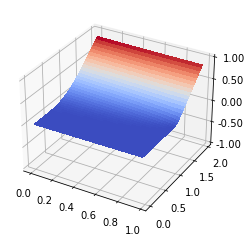

In [9]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf = ax.plot_surface(t, St, V_c, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')
plt.show()

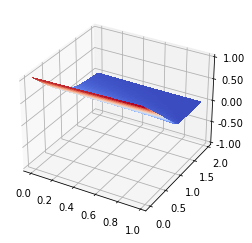

In [10]:
fig1, ax1 = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf1 = ax1.plot_surface(t, St, V_p, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax1.set_zlim(-1.01, 1.01)
# A StrMethodFormatter is used automatically
ax1.zaxis.set_major_formatter('{x:.02f}')
plt.show()

In [11]:
#Plot the analytical solution as a function of the log price 
j=np.log(K/S0)
xt=np.arange(-1,1,0.05)
t2=np.arange(0,T,0.025)
xt,t2=np.meshgrid(xt,t2)
d__2=(xt-j+muABM*(T-t2))/(sigma*np.sqrt(T-t2))
d__1=d__2+sigma*np.sqrt(T-t2)
V_c1=S0*np.exp(xt-q*(T-t2))*norm.cdf(d__1,0,1)- np.exp(j-r*(T-t2))*norm.cdf(d__2,0,1)
V_p1=S0*np.exp(j-r*(T-t2))*norm.cdf(-d__2,0,1)- np.exp(xt-q*(T-t2))*norm.cdf(-d__1,0,1)

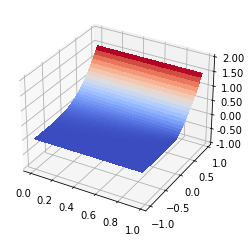

In [12]:
fig2, ax2 = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf2 = ax2.plot_surface(t2, xt, V_c1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax2.set_zlim(-1.01, 2.01)
# A StrMethodFormatter is used automatically
ax2.zaxis.set_major_formatter('{x:.02f}')
plt.show()

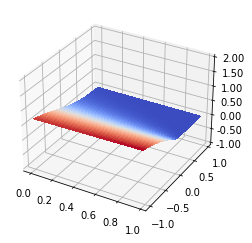

In [13]:
fig4, ax4 = plt.subplots(subplot_kw={"projection": "3d"})
# Plot the surface.
surf4 = ax4.plot_surface(t2, xt, V_p1, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
# Customize the z axis.
ax4.set_zlim(-1.01, 2.01)
# A StrMethodFormatter is used automatically
ax4.zaxis.set_major_formatter('{x:.02f}')
plt.show()